In [ ]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai

In [3]:
# General utilities
import os
import gc
import re
import json
import time
import shutil
import random
import csv
from statistics import mean

# Numerical and scientific libraries
import numpy as np
import pandas as pd
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, confusion_matrix, matthews_corrcoef, jaccard_score
)

# Image processing
import cv2
from PIL import Image
from imgaug import augmenters as iaa
from imgaug import SegmentationMapsOnImage

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, _LRScheduler

# Torchvision
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# MONAI and Transformers
import monai
from transformers import SamModel, SamProcessor

# Segmentation models
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Torchmetrics
from torchmetrics import ConfusionMatrix

# HuggingFace Datasets
from datasets import Dataset

# Progress bar
from tqdm import tqdm



default_matplotlib_backend = matplotlib.get_backend()
print('imported')
print('default_matplotlib_backend: {}'.format(default_matplotlib_backend))

print(' numpy version', np.__version__) 

/home/rsaric/plant_segmentation/plant_seg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/rsaric/plant_segmentation/plant_seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imported
default_matplotlib_backend: module://matplotlib_inline.backend_inline
 numpy version 1.26.0


In [5]:

# Augmentation lists (reuse from CustomDataset)
augmentations_list = [
    iaa.Sharpen(alpha=(0, 0.5), lightness=(2.5, 3.0)),
    iaa.GammaContrast((0.4, 0.9)),
    iaa.AddToHueAndSaturation((-40, 20)),
    iaa.Multiply((1.1, 1.8))
]
zoomin_list = [
    iaa.Affine(scale=(1.2, 1.8)),
    iaa.Crop(percent=(0.01, 0.3))
]

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# SAMDataset with Augmentations
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor, augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def transform(self, image, mask):
        resize = transforms.Resize(size=(512, 512))
        if self.augmentations:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.randrange(45, 270)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            if random.random() > 0.6:
                image_np = np.array(image)
                bg_images_folder = ""  # Update with your BG folder path
                bg_images_list = [
                    f for f in os.listdir(bg_images_folder)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ]

                if not bg_images_list:
                    raise ValueError("No valid background images found in the specified folder.")

                bg_image_choice = random.choice(bg_images_list)
                bg_image_path = os.path.join(bg_images_folder, bg_image_choice)

                # Read the background image
                background_image = cv2.imread(bg_image_path)

                if background_image is None:
                    raise ValueError(f"Failed to load background image: {bg_image_path}")

                # Resize the background image
                background_image = cv2.resize(background_image, (image_np.shape[1], image_np.shape[0]))

                # Combine with segmentation
                seg_image = np.where(mask == 0, 0, image_np)
                seg_image_with_background = np.where(seg_image != 0, 0, background_image)
                image = cv2.add(seg_image, seg_image_with_background)
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if random.random() > 0.5:
                image_np = np.array(image)
                selected_augmentation = random.choice(augmentations_list)
                image_np = selected_augmentation.augment_image(image_np)
                image = Image.fromarray(image_np)
            if random.random() > 0.5:
                image_np = np.array(image)
                mask_np = np.array(mask)
                selected_augmentation = random.choice(zoomin_list)
                aug = iaa.Sequential([selected_augmentation])
                mask_segmaps = SegmentationMapsOnImage(mask_np, shape=mask_np.shape)
                zoom_image_np, masks_aug = aug(image=image_np, segmentation_maps=mask_segmaps)
                zoom_mask_np = masks_aug.get_arr()
                image = Image.fromarray(zoom_image_np)
                mask = Image.fromarray(zoom_mask_np)
    
        image = resize(image)
        mask = resize(mask)
        return image, mask

    def __getitem__(self, idx):
        try:
            # Load image and mask paths
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]

            # Open image and mask
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Apply augmentations or transformations
            image, mask = self.transform(image, mask)
            image = np.array(image)
            # Get bounding box prompt from the mask
            ground_truth_mask = np.array(mask)
            prompt = get_bounding_box(ground_truth_mask)

            # Prepare inputs for the processor
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

            # Remove batch dimension added by the processor
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # Add ground truth segmentation mask to the inputs
            inputs["ground_truth_mask"] = ground_truth_mask

            return inputs

        except Exception as e:
            # Log the error and skip the problematic data point
            print(f"Error loading data at index {idx}: {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Move to the next item

In [6]:
# Load dataset file paths
def get_file_paths(data_dict, base_dir, base_dir_label):
    train_image_paths, val_image_paths, test_image_paths = [], [], []
    train_mask_paths, val_mask_paths, test_mask_paths = [], [], []
    for dataset, splits in data_dict.items():
        for rep, split in splits.items():
            for f in os.listdir(os.path.join(base_dir, dataset, rep)):
                image_path = os.path.join(base_dir, dataset, rep, f)
                mask_path = os.path.join(base_dir_label, dataset, rep, "masks", f.replace('.png', '_mask.png'))
                if split == 'train':
                    train_image_paths.append(image_path)
                    train_mask_paths.append(mask_path)
                elif split == 'valid':
                    val_image_paths.append(image_path)
                    val_mask_paths.append(mask_path)
                elif split == 'test':
                    test_image_paths.append(image_path)
                    test_mask_paths.append(mask_path)
    return train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths

In [7]:
# Dataset-1 configuration
# Load data
train_valid_test_split_json_name_ds1 = ''
with open(train_valid_test_split_json_name_ds1, 'r') as f:
    data_dict_ds1 = json.load(f)

base_dir_ds1       = ""
base_dir_label_ds1 = ""

train_image_paths_ds1, train_mask_paths_ds1, val_image_paths_ds1, val_mask_paths_ds1, test_image_paths_ds1, test_mask_paths_ds1 = get_file_paths(
    data_dict_ds1, base_dir_ds1, base_dir_label_ds1
)

print('Dataset-1:')
print('Number of training images:', len(train_image_paths_ds1))
print('Number of validation images:', len(val_image_paths_ds1))
print('Number of test images:', len(test_image_paths_ds1))
print("DataLoaders ready for Dataset-1!")


# Dataset-2 configuration
# Load data
train_valid_test_split_json_name_ds2 = ''
with open(train_valid_test_split_json_name_ds2, 'r') as f:
    data_dict_ds2 = json.load(f)

base_dir_ds2       = ""
base_dir_label_ds2 = ""

train_image_paths_ds2, train_mask_paths_ds2, val_image_paths_ds2, val_mask_paths_ds2, test_image_paths_ds2, test_mask_paths_ds2 = get_file_paths(
    data_dict_ds2, base_dir_ds2, base_dir_label_ds2
)

print('Dataset-2:')
print('Number of training images:', len(train_image_paths_ds2))
print('Number of validation images:', len(val_image_paths_ds2))
print('Number of test images:',      len(test_image_paths_ds2))
print("DataLoaders ready for Dataset-2!")

Dataset-1:
Number of training images: 10634
Number of validation images: 2318
Number of test images: 1156
DataLoaders ready for Dataset-1!
Dataset-2:
Number of training images: 12656
Number of validation images: 3906
Number of test images: 1997
DataLoaders ready for Dataset-2!


In [8]:
 # Instantiate the processor (SAM model-specific)
from transformers import SamProcessor  
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")  # Update with your SAM model

In [9]:
def create_datasets(image_paths, mask_paths, processor, augmentations, dataset_number):
    """
    Create datasets with or without augmentation for a specific dataset number.
    
    Args:
        image_paths (list): List of image file paths.
        mask_paths (list): List of mask file paths.
        processor: The processor object for handling the dataset.
        augmentations (bool): Whether to apply augmentations.
        dataset_number (int): Dataset identifier (e.g., 1 or 2).

    Returns:
        tuple: Datasets (train, validation, test) with specified configurations.
    """
    train_dataset = SAMDataset(
        image_paths["train"], mask_paths["train"], processor, augmentations=augmentations
    )
    val_dataset = SAMDataset(
        image_paths["val"], mask_paths["val"], processor, augmentations=False
    )
    test_dataset = SAMDataset(
        image_paths["test"], mask_paths["test"], processor, augmentations=False
    )

    print(f"Dataset-{dataset_number} with {'augmentations' if augmentations else 'no augmentations'} created.")
    return train_dataset, val_dataset, test_dataset


# Example usage for Dataset-1
image_paths_ds1 = {
    "train": train_image_paths_ds1,
    "val": val_image_paths_ds1,
    "test": test_image_paths_ds1,
}
mask_paths_ds1 = {
    "train": train_mask_paths_ds1,
    "val": val_mask_paths_ds1,
    "test": test_mask_paths_ds1,
}

train_dataset_ds1, val_dataset_ds1, test_dataset_ds1 = create_datasets(
    image_paths_ds1, mask_paths_ds1, processor, augmentations=False, dataset_number=1
)

train_dataset_aug_ds1, val_dataset_aug_ds1, test_dataset_aug_ds1 = create_datasets(
    image_paths_ds1, mask_paths_ds1, processor, augmentations=True, dataset_number=1
)

# Example usage for Dataset-2
image_paths_ds2 = {
    "train": train_image_paths_ds2,
    "val": val_image_paths_ds2,
    "test": test_image_paths_ds2,
}
mask_paths_ds2 = {
    "train": train_mask_paths_ds2,
    "val": val_mask_paths_ds2,
    "test": test_mask_paths_ds2,
}

train_dataset_ds2, val_dataset_ds2, test_dataset_ds2 = create_datasets(
    image_paths_ds2, mask_paths_ds2, processor, augmentations=False, dataset_number=2
)

train_dataset_aug_ds2, val_dataset_aug_ds2, test_dataset_aug_ds2 = create_datasets(
    image_paths_ds2, mask_paths_ds2, processor, augmentations=True, dataset_number=2
)

Dataset-1 with no augmentations created.
Dataset-1 with augmentations created.
Dataset-2 with no augmentations created.
Dataset-2 with augmentations created.


In [10]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"DataLoaders created with batch size {batch_size}.")
    return train_loader, val_loader, test_loader


# Example usage for Dataset-1 without augmentations
batch_size = 8
train_loader_ds1, val_loader_ds1, test_loader_ds1 = create_dataloaders(
    train_dataset_ds1, val_dataset_ds1, test_dataset_ds1, batch_size
)

# Example usage for Dataset-1 with augmentations
train_loader_aug_ds1, val_loader_aug_ds1, test_loader_aug_ds1 = create_dataloaders(
    train_dataset_aug_ds1, val_dataset_aug_ds1, test_dataset_aug_ds1, batch_size
)

# Example usage for Dataset-2 without augmentations
train_loader_ds2, val_loader_ds2, test_loader_ds2 = create_dataloaders(
    train_dataset_ds2, val_dataset_ds2, test_dataset_ds2, batch_size
)

# Example usage for Dataset-2 with augmentations
train_loader_aug_ds2, val_loader_aug_ds2, test_loader_aug_ds2 = create_dataloaders(
    train_dataset_aug_ds2, val_dataset_aug_ds2, test_dataset_aug_ds2, batch_size
)

DataLoaders created with batch size 8.
DataLoaders created with batch size 8.
DataLoaders created with batch size 8.
DataLoaders created with batch size 8.


In [20]:
def plot_sample_with_bbox(data_loader):
    """
    Plots a sample image with its bounding box (prompt for SAM) and mask from the DataLoader.
    Prints the shape, min, and max value of each.
    
    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing image and mask data.
    """
    # Get one batch of data
    batch = next(iter(data_loader))
    
    # Extract the first sample from the batch
    image_tensor = batch["pixel_values"]  # Assuming processor output has key "pixel_values"
    mask_tensor = batch["ground_truth_mask"]  # Assuming mask is included with this key
    
    # Convert tensors to numpy arrays for visualization
    image = image_tensor[0].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    mask  = mask_tensor[0].numpy()  # Convert mask to numpy array
    
    # Get the bounding box (assumed to be present in the batch as 'input_boxes')
    bbox = batch["input_boxes"][0][0]  # Extract the first bounding box from the batch
    
    # Bounding box coordinates
    x_min, y_min, x_max, y_max = bbox
    
    # Print shape, min, and max of the image
    print(f"Image shape: {image.shape}, Min: {image.min()}, Max: {image.max()}")
    
    # Print shape, min, and max of the mask
    print(f"Mask shape: {mask.shape}, Min: {mask.min()}, Max: {mask.max()}")
    
    # Print bounding box coordinates
    print(f"Bounding box: [x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}]")
    
    # Plot the image with the bounding box
    plt.figure(figsize=(12, 6))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow((image - image.min()) / (image.max() - image.min()))  # Normalize for display
    plt.title("Sample Image with Bounding Box")
    plt.axis("off")
    
    # Draw the bounding box
    ax = plt.gca()
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                     linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Sample Mask")
    plt.axis("off")
    
    plt.show()

In [18]:
def save_samples(data_loader, output_dir="aug_samples", num_samples=30, save_with_bbox=True):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize a counter for saved images
    saved_count = 0

    # Iterate through the DataLoader
    for batch in data_loader:
        if saved_count >= num_samples:
            break
        
        # Extract batch data
        image_tensors = batch["pixel_values"]  # Assuming processor output has key "pixel_values"
        bboxes = batch["input_boxes"]  # Assuming bounding boxes are included with this key
        mask_tensor = batch["ground_truth_mask"]  # Assuming mask is included with this key
        mask  = mask_tensor[0].numpy()  # Convert mask to numpy array
        
        # Process each image in the batch
        for i in range(len(image_tensors)):
            if saved_count >= num_samples:
                break
            
            # Convert tensor to numpy for visualization
            image = image_tensors[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
            bbox = bboxes[i][0]  # Extract the first bounding box for this image
            
            # Bounding box coordinates
            x_min, y_min, x_max, y_max = bbox
            
            # Normalize the image for display
            image_normalized = (image - image.min()) / (image.max() - image.min())
            
            # Plot the image
            plt.figure(figsize=(6, 6))
            plt.imshow(image_normalized)
            plt.title("Image" + (" with Bounding Box" if save_with_bbox else ""))
            plt.axis("off")
            
            # Optionally draw the bounding box
            if save_with_bbox:
                ax = plt.gca()
                rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            
            # Save the image
            save_path = os.path.join(output_dir, f"sample_{saved_count + 1}.png")
            plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
            plt.close()
            
            # Increment the counter
            saved_count += 1

    print(f"Saved {saved_count} samples in the directory: {output_dir}")



In [19]:
# Save images with bounding boxes
save_samples(train_loader_aug_ds1, output_dir="aug_samples", num_samples=30, save_with_bbox=False)

# Save images without bounding boxes
save_samples(train_loader_ds1, output_dir="sam_samples", num_samples=30, save_with_bbox=True)

Saved 30 samples in the directory: aug_samples
Saved 30 samples in the directory: sam_samples


Image shape: (1024, 1024, 3), Min: -2.1179039478302, Max: 0.6705012917518616
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 288.0, y_min: 300.0, x_max: 744.0, y_max: 730.0]


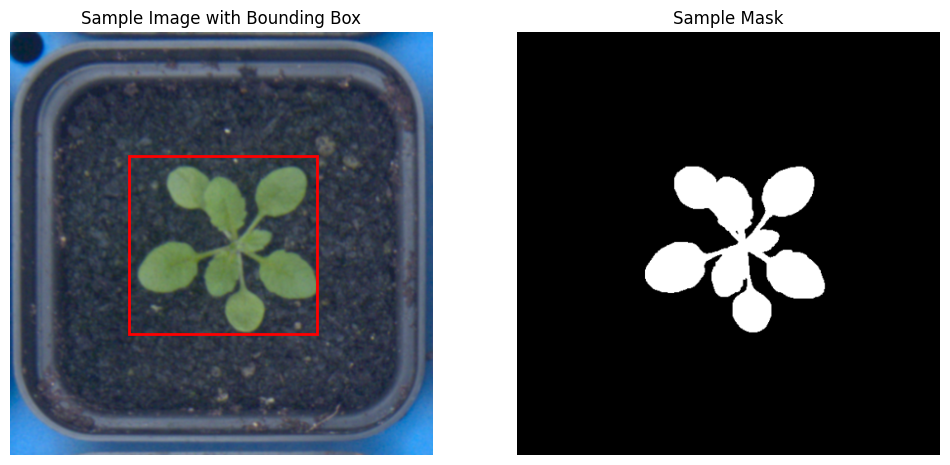

In [38]:
plot_sample_with_bbox(train_loader_ds1)

Image shape: (1024, 1024, 3), Min: -2.0836544036865234, Max: 1.315381407737732
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 280.0, y_min: 268.0, x_max: 784.0, y_max: 752.0]


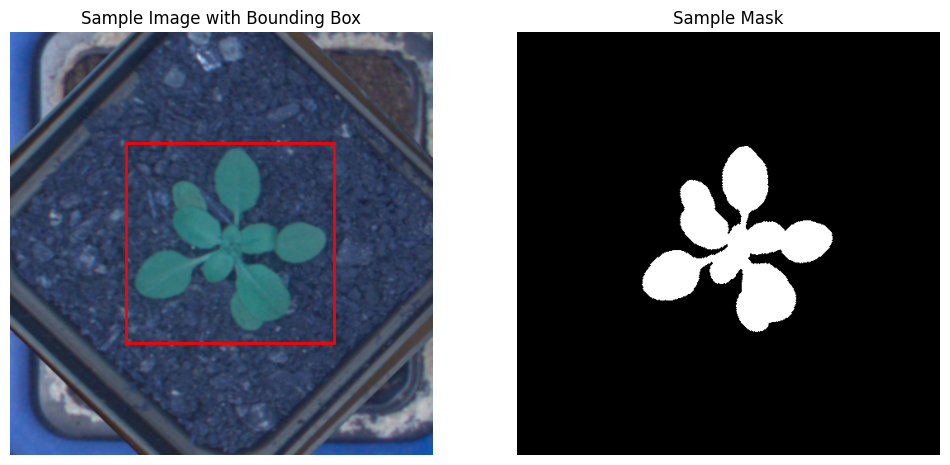

In [39]:
plot_sample_with_bbox(train_loader_aug_ds1)

Image shape: (1024, 1024, 3), Min: -2.1179039478302, Max: 1.4373857975006104
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 286.0, y_min: 372.0, x_max: 644.0, y_max: 682.0]


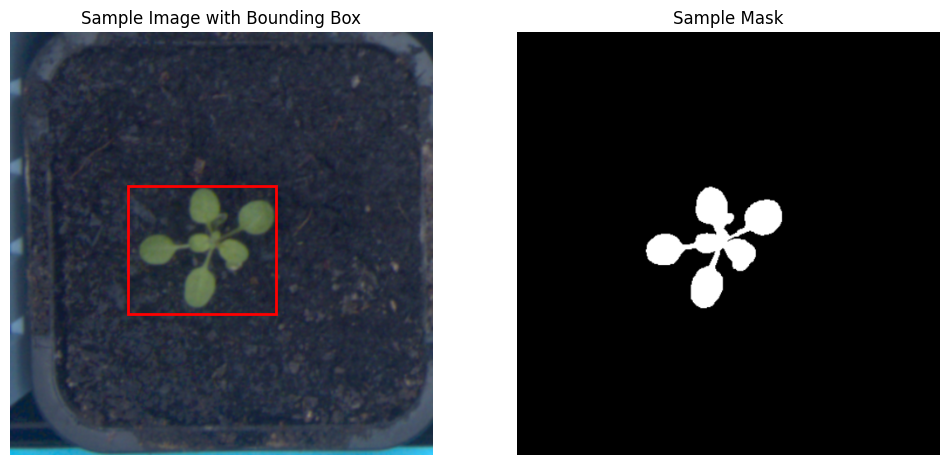

In [40]:
plot_sample_with_bbox(train_loader_ds2)

Image shape: (1024, 1024, 3), Min: -1.9295316934585571, Max: 1.6757702827453613
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 468.0, y_min: 406.0, x_max: 636.0, y_max: 604.0]


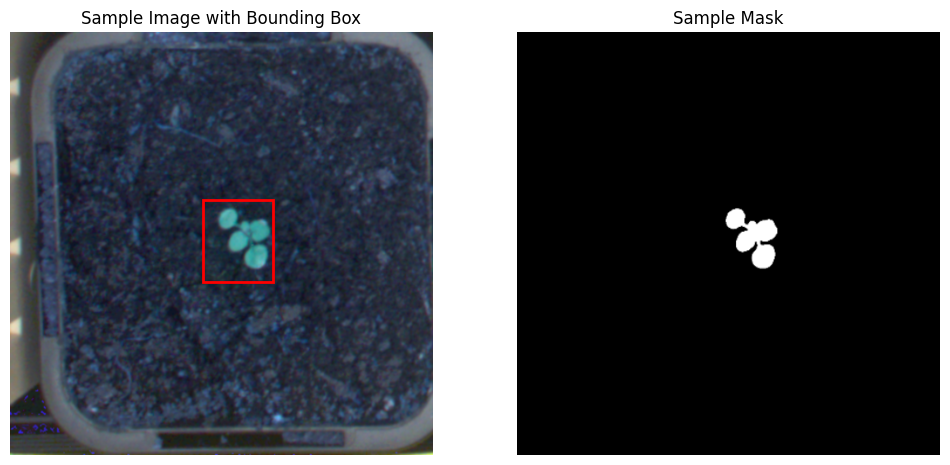

In [41]:
plot_sample_with_bbox(train_loader_aug_ds2)

Image shape: (1024, 1024, 3), Min: -2.1007792949676514, Max: 0.008191797882318497
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 0.0, y_min: 88.0, x_max: 838.0, y_max: 898.0]


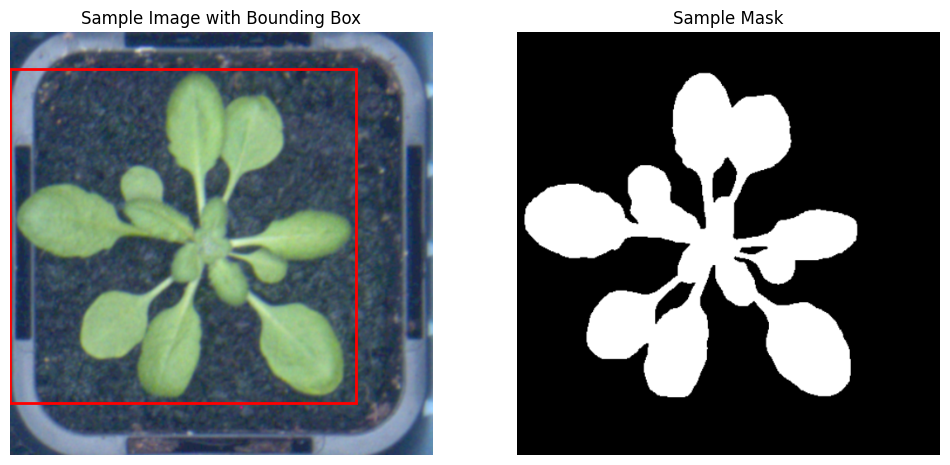

In [77]:
plot_sample_with_bbox(val_loader_aug_ds2)

In [12]:
def train_sam_model(
    model, optimizer, seg_loss, train_loader, val_loader,
    num_epochs=1, device="cuda", patience_lr=5, patience_early_stop=20, save_path="sam_model"
):
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Move model to device
    model = model.to(device)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience_lr, verbose=True)

    # Initialize variables for early stopping and best model saving
    best_val_iou = 0
    best_model_path = os.path.join(save_path, "best_sam_model.pth")
    epochs_no_improve = 0
    bat_num = 0
    stop_batch = 0
    for epoch in range(num_epochs):
        epoch_losses = []
        print(f"\n--- Starting Epoch {epoch + 1}/{num_epochs} ---")

        # Training loop
        model.train()
        for batch_idx, batch in enumerate(train_loader, start=1):
            # Move inputs to the appropriate device
            pixel_values = batch["pixel_values"].to(device)
            input_boxes = batch["input_boxes"].to(device)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            # Forward pass
            outputs = model(
                pixel_values=pixel_values,
                input_boxes=input_boxes,
                multimask_output=False
            )
            predicted_masks = outputs.pred_masks.squeeze(1)

            # Resize ground truth masks to match predictions
            ground_truth_masks = ground_truth_masks / 255.0 if ground_truth_masks.max() > 1 else ground_truth_masks
            ground_truth_masks = F.interpolate(
                ground_truth_masks.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False
            ).squeeze(1)

            # Compute loss
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Optimize
            optimizer.step()

            # Append batch loss
            epoch_losses.append(loss.item())

            # Inline print
            print(f"\r[Train] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}", end="")
            # stop_batch += 1
            # if stop_batch == 5:
            #     stop_batch = 0
            #     break
        print()  # Move to the next line after the epoch

        # Print epoch summary
        mean_train_loss = mean(epoch_losses)
        print(f"Mean Training Loss: {mean_train_loss:.4f}")

        # Validation loop and metrics calculation
        print("\n--- Starting Validation ---")
        val_loss, val_iou = validate_sam_model(model, seg_loss, val_loader, device)

        # Update learning rate scheduler
        scheduler.step(val_iou)

        # Save model every 4 epochs
        if (epoch + 1) % 4 == 0:
            save_checkpoint_path = os.path.join(save_path, f"sam_model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), save_checkpoint_path)
            print(f"Model checkpoint saved at {save_checkpoint_path}")

        # Save the best model based on validation IoU
        if val_iou > best_val_iou:
            print(f"Validation IoU improved from {best_val_iou:.4f} to {val_iou:.4f}")
            best_val_iou = val_iou
            epochs_no_improve = 0  # Reset early stopping counter
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in Validation IoU for {epochs_no_improve} epoch(s)")

        # Check for early stopping
        if epochs_no_improve >= patience_early_stop:
            print("Early stopping triggered. Training stopped.")
            break

    print("Training completed...")

In [13]:
def calculate_iou(predicted, ground_truth):
    """Calculate IoU from the difference between masks."""
    # Subtract predicted mask from ground truth mask
    difference_mask = np.abs(predicted - ground_truth)
    
    # Count black pixels (agreement)
    black_pixels = np.sum(difference_mask == 0)
    
    # Total number of pixels
    total_pixels = difference_mask.size
    
    # IoU is the ratio of black pixels to total pixels
    return black_pixels / total_pixels if total_pixels != 0 else 0


def validate_sam_model(model, seg_loss, val_loader, device="cuda"):
    model.eval()
    val_losses = []
    total_iou = 0
    num_samples = 0

    print("\n--- Validation Started ---")
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader, start=1):
            # Move inputs to device
            pixel_values = batch["pixel_values"].to(device)
            input_boxes = batch["input_boxes"].to(device)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            # Forward pass
            outputs = model(
                pixel_values=pixel_values,
                input_boxes=input_boxes,
                multimask_output=False
            )
            predicted_masks = outputs.pred_masks.squeeze(1)

            # Resize ground truth masks to match predictions
            ground_truth_masks = ground_truth_masks / 255.0 if ground_truth_masks.max() > 1 else ground_truth_masks
            ground_truth_masks = F.interpolate(
                ground_truth_masks.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False
            ).squeeze(1)

            # Compute loss
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

            # Threshold binary masks
            predicted_masks_binary = (predicted_masks > 0.3).cpu().numpy().astype(np.uint8)
            ground_truth_binary = (ground_truth_masks > 0.5).cpu().numpy().astype(np.uint8)

            # Calculate IoU using the black pixel method
            batch_ious = []
            for i in range(len(predicted_masks_binary)):
                iou = calculate_iou(predicted_masks_binary[i], ground_truth_binary[i])
                batch_ious.append(iou)

            # Aggregate IoU
            total_iou += sum(batch_ious)
            num_samples += len(batch_ious)

            # Inline print
            print(
                f"\r[Validation] Batch {batch_idx}/{len(val_loader)} - Loss: {loss.item():.4f}, "
                f"Batch IoU: {mean(batch_ious):.4f}", end=""
            )
    # Compute mean IoU and loss
    mean_val_loss = mean(val_losses)
    mean_val_iou = total_iou / num_samples

    print("\n--- Validation Summary ---")
    print(f"Mean Validation Loss: {mean_val_loss:.4f}")
    print(f"Mean Validation IoU: {mean_val_iou:.4f}")

    return mean_val_loss, mean_val_iou

In [14]:
def calculate_iou(predicted, ground_truth):
    """Calculate IoU based on black pixels from the difference between masks."""
    # Subtract predicted mask from ground truth mask
    difference_mask = np.abs(predicted - ground_truth)
    
    # Count black pixels (agreement)
    black_pixels = np.sum(difference_mask == 0)
    
    # Total number of pixels
    total_pixels = difference_mask.size
    
    # IoU is the ratio of black pixels to total pixels
    return black_pixels / total_pixels if total_pixels != 0 else 0

def evaluate_model(
    model, 
    test_loader, 
    folder_path, 
    augmentation=False, 
    dataset_number=1, 
    device="cuda"
):
    model.eval()
    model.to(device)

    all_targets = []
    all_preds = []

    iou_scores = []  # Store IoU scores for all masks
    iou_plant_score = 0.0  # Initialize IoU for the single class

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            images = batch["pixel_values"].to(device)
            ground_truth_masks = batch["ground_truth_mask"].to(device)
            input_boxes = batch["input_boxes"].to(device)

            outputs = model(
                pixel_values=images,
                input_boxes=input_boxes,
                multimask_output=False
            )
            predicted_probs = outputs.pred_masks

            if predicted_probs.dim() == 5 and predicted_probs.shape[2] == 1:
                predicted_probs = predicted_probs.squeeze(2)

            predicted_probs_resized = F.interpolate(
                predicted_probs, size=ground_truth_masks.shape[-2:], mode="bilinear", align_corners=False
            )

            predicted_masks_resized = (predicted_probs_resized > 0.5).float()

            all_targets.append(ground_truth_masks.cpu().numpy().ravel())
            all_preds.append(predicted_masks_resized.cpu().numpy().ravel())

            # Calculate IoU for each mask
            for i in range(ground_truth_masks.shape[0]):
                pred_mask = predicted_masks_resized[i].cpu().numpy()
                true_mask = ground_truth_masks[i].cpu().numpy()

                # Binarize the masks
                pred_mask = (pred_mask > 0.5).astype(int)
                true_mask = (true_mask > 0.5).astype(int)

                # Compute IoU using the calculate_iou function
                iou = calculate_iou(pred_mask, true_mask)
                iou_scores.append(iou)

    all_targets = np.concatenate(all_targets)
    all_preds   = np.concatenate(all_preds)
    all_targets = (all_targets > 0.5).astype(int)
    all_preds   = (all_preds   > 0.5).astype(int)

    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds, labels=[0, 1]).ravel()

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_discovery_rate = fp / (fp + tp) if (fp + tp) > 0 else 0
    false_omission_rate = fn / (fn + tn) if (fn + tn) > 0 else 0
    geometric_mean = round(np.sqrt(precision * recall), 2)
    mcc = matthews_corrcoef(all_targets, all_preds)
    iou = np.mean(iou_scores)

    print("Test metrics (on test set)")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy * 100:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"False Discovery Rate: {false_discovery_rate:.4f}")
    print(f"False Omission Rate: {false_omission_rate:.4f}")
    print(f"Geometric Mean: {geometric_mean:.2f}")
    print(f"Matthew's Correlation Coefficient: {mcc:.2f}")
    print(f"Mean IoU: {iou:.2f}")

    file_name = f"results_dataset{dataset_number}"
    if augmentation:
        file_name += "_aug"
    file_name += ".csv"
    csv_path = os.path.join(folder_path, file_name)

    os.makedirs(folder_path, exist_ok=True)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity,
        "False Positive Rate": false_positive_rate,
        "False Negative Rate": false_negative_rate,
        "False Discovery Rate": false_discovery_rate,
        "False Omission Rate": false_omission_rate,
        "Geometric Mean": geometric_mean,
        "MCC": mcc,
        "Mean IoU": iou,
    }

    with open(csv_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Metric", "Value"])
        for metric, value in metrics.items():
            writer.writerow([metric, value])

    print(f"Metrics saved to {csv_path}")

    fpr, tpr, _ = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [15]:
def infer_and_visualize(model, val_loader, device="cuda", num_samples=6):
    """model
    Perform inference on the validation loader and visualize the input image, predicted mask, and ground truth mask.

    Args:
        model (torch.nn.Module): The trained SAM model.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (str): Device to use for inference ("cuda" or "cpu").
        num_samples (int): Number of samples to visualize.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    images_to_plot = []
    predicted_masks_to_plot = []
    ground_truth_masks_to_plot = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["pixel_values"].to(device)  # Input images
            ground_truth_masks = batch["ground_truth_mask"].to(device)  # Ground truth masks
            input_boxes = batch["input_boxes"].to(device)  # Input boxes for prompts

            # Perform inference
            outputs = model(
                pixel_values=images,
                input_boxes=input_boxes,
                multimask_output=False
            )
            predicted_masks = torch.sigmoid(outputs.pred_masks)  # Apply sigmoid to predictions

            # Ensure predicted_masks has the correct shape (N, C, H, W) for interpolation
            if predicted_masks.dim() == 5 and predicted_masks.shape[2] == 1:  # Handle extra dimension
                predicted_masks = predicted_masks.squeeze(2)  # Remove the unnecessary dimension

            # Resize predicted masks to 512x512 for visualization
            predicted_masks_resized = F.interpolate(
                predicted_masks, size=(512, 512), mode="bilinear", align_corners=False
            )

            # Binarize the masks
            predicted_masks_resized = (predicted_masks_resized > 0.5).cpu().numpy().astype(np.uint8)
            ground_truth_masks = (ground_truth_masks > 0.5).cpu().numpy().astype(np.uint8)

            # Store the first `num_samples` samples for plotting
            images_to_plot.extend(images.cpu())
            predicted_masks_to_plot.extend(predicted_masks_resized)  # Do not call .cpu() here
            ground_truth_masks_to_plot.extend(ground_truth_masks)  # Do not call .cpu() here
            
            # Stop if we have enough samples
            if len(images_to_plot) >= num_samples:
                break

    # Visualize the samples
    for i in range(num_samples):
        # Convert tensors to numpy arrays for visualization
        image = images_to_plot[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        predicted_mask = predicted_masks_to_plot[i][0]  # Extract the resized mask
        ground_truth_mask = ground_truth_masks_to_plot[i]

        # Normalize the image for display
        image = (image - image.min()) / (image.max() - image.min())

        # Plot the image, predicted mask, and ground truth mask
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.title("Predicted Mask (Resized to 512x512)")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        plt.show()

In [16]:
def configure_loaders_and_save_path(
    train_loader, val_loader, test_loader, 
    train_loader_aug, val_loader_aug, test_loader_aug,
    use_augmentation, save_path, dataset_number
):
    """
    Configure existing DataLoaders and update the save path based on augmentation usage and dataset number.
    """
    if use_augmentation:
        selected_train_loader = train_loader_aug
        selected_val_loader = val_loader_aug
        selected_test_loader = test_loader_aug
        save_path = f"{save_path}_dataset{dataset_number}_aug"
    else:
        selected_train_loader = train_loader
        selected_val_loader = val_loader
        selected_test_loader = test_loader
        save_path = f"{save_path}_dataset{dataset_number}"

    print(f"Using {'augmentation' if use_augmentation else 'standard'} loaders for Dataset-{dataset_number}.")
    print(f"Model will be saved at: {save_path}")
    
    return selected_train_loader, selected_val_loader, selected_test_loader, save_path


In [17]:
USE_2_GPUS = False  

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze parts of the model if needed
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Multi-GPU or single-GPU setup
if USE_2_GPUS and torch.cuda.device_count() > 1:
    print("Using DataParallel for multi-GPU training.")
    model = nn.DataParallel(model)

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Use model.module.mask_decoder.parameters() if model is wrapped with DataParallel
if isinstance(model, torch.nn.DataParallel):
    optimizer = Adam(model.module.mask_decoder.parameters(), lr=0.0001, weight_decay=0)
else:
    optimizer = Adam(model.mask_decoder.parameters(), lr=0.0001, weight_decay=0)
# Define the loss function
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [243]:
# Dataset-1, Augmentation
use_augmentation = True
dataset_number = 1
save_path_base = "results_sam/models/sam_model"

train_loader_ds1, val_loader_ds1, test_loader_ds1, save_path_ds1 = configure_loaders_and_save_path(
    train_loader=train_loader_ds1,
    val_loader=val_loader_ds1,
    test_loader=test_loader_ds1,
    train_loader_aug=train_loader_aug_ds1,
    val_loader_aug=val_loader_aug_ds1,
    test_loader_aug=test_loader_aug_ds1,
    use_augmentation=use_augmentation,
    save_path=save_path_base,
    dataset_number=1
)


# Training the model for Dataset-1
train_sam_model(
    model=model,
    optimizer=optimizer,
    seg_loss=seg_loss,
    train_loader=train_loader_ds1,
    val_loader=val_loader_ds1,
    num_epochs=10000,
    device="cuda",
    patience_lr=5,
    patience_early_stop=20,
    save_path=save_path_ds1
)   

In [244]:
path = ""
model.load_state_dict(torch.load(path, map_location="cuda"))

In [245]:
evaluate_model(
    model=model,
    test_loader=test_loader_ds1,
    folder_path="./results_sam/results_sam_csv",
    augmentation=use_augmentation,
    dataset_number=dataset_number,
    device="cuda"
)

In [246]:
infer_and_visualize(model, test_loader_ds1, device="cuda", num_samples=20)

In [19]:
USE_2_GPUS = False  

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze parts of the model if needed
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Multi-GPU or single-GPU setup
if USE_2_GPUS and torch.cuda.device_count() > 1:
    print("Using DataParallel for multi-GPU training.")
    model = nn.DataParallel(model)

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
# Dataset-2, Augmentation
use_augmentation = False
dataset_number = 2
save_path_base = "results_sam/models/sam_model"

train_loader_ds2, val_loader_ds2, test_loader_ds2, save_path_ds2 = configure_loaders_and_save_path(
    train_loader=train_loader_ds2,
    val_loader=val_loader_ds2,
    test_loader=test_loader_ds2,
    train_loader_aug=train_loader_aug_ds2,
    val_loader_aug=val_loader_aug_ds2,
    test_loader_aug=test_loader_aug_ds2,
    use_augmentation=use_augmentation,
    save_path=save_path_base,
    dataset_number=dataset_number
)

# Training the model for Dataset-2
train_sam_model(
    model=model,
    optimizer=optimizer,
    seg_loss=seg_loss,
    train_loader=train_loader_ds2,
    val_loader=val_loader_ds2,
    num_epochs=10000,
    device="cuda",
    patience_lr=5,
    patience_early_stop=20,
    save_path=save_path_ds2
)

Using standard loaders for Dataset-2.
Model will be saved at: results_sam/models/sam_model_dataset2

--- Starting Epoch 1/10000 ---


/home/rsaric/plant_segmentation/plant_seg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Train] Batch 1582/1582 - Loss: 0.0352
Mean Training Loss: 0.1158

--- Starting Validation ---

--- Validation Started ---
[Validation] Batch 489/489 - Loss: 0.0405, Batch IoU: 0.9990

--- Validation Summary ---
Mean Validation Loss: 0.0972
Mean Validation IoU: 0.9795
Validation IoU improved from 0.0000 to 0.9795
Best model saved at results_sam/models/sam_model_dataset2/best_sam_model.pth

--- Starting Epoch 2/10000 ---
[Train] Batch 1582/1582 - Loss: 0.0371
Mean Training Loss: 0.1153

--- Starting Validation ---

--- Validation Started ---
[Validation] Batch 489/489 - Loss: 0.0383, Batch IoU: 0.9991

--- Validation Summary ---
Mean Validation Loss: 0.0951
Mean Validation IoU: 0.9801
Validation IoU improved from 0.9795 to 0.9801
Best model saved at results_sam/models/sam_model_dataset2/best_sam_model.pth

--- Starting Epoch 3/10000 ---
[Train] Batch 1582/1582 - Loss: 0.0289
Mean Training Loss: 0.1142

--- Starting Validation ---

--- Validation Started ---
[Validation] Batch 489/489 - 